## sigMF RF classification; 12 classes

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data
import torch.utils.data as data
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import glob
import json
from os import walk
import pickle
import json
import pathlib
import random
from timeit import default_timer as timer
import time
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
global GPU, fft, Fs, center_freq, fft_val, Fs_test, loss, batches, eps, var_noise, mean_noise, top
global c1_coeff, c2_coeff, a, r1_c1, r2_c1, r1_c2, r2_c2, compare
a = 1
compare = .5
r1_c2 = 1
r2_c2 = 10e1
top = .97
var_noise = 8.78e-09
# mean_noise = 10 # worked pretty good
mean_noise = 1
eps = 1e-15
Fs = 1000000
fft = 1024
center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz
center_freq_live = 428.00e6 # when SDR doing 25MSPS with center at 428MHz
batches = 64
plt.style.use('default')
GPU = 1
device = torch.device('cuda:1')
print('Torch version =', torch.__version__, 'CUDA version =', torch.version.cuda)
print('CUDA Device:', device)
print('Is cuda available? =',torch.cuda.is_available())

Torch version = 1.6.0 CUDA version = 10.2
CUDA Device: cuda:1
Is cuda available? = True


In [2]:
!. /home/david/prefix-3.8/setup_env.sh

#### Machine paths

In [3]:
path_ram = "/home/david/sigMF_ML/RF/ramdisk/"
path_usrp = "/home/david/prefix-3.8/"
path = "/home/david/sigMF_ML/RF/RF_class/data/" # ACE
path_val1 = "/home/david/sigMF_ML/RF/RF_class/data_val1/" # fft_center    - class 9
path_val2 = "/home/david/sigMF_ML/RF/RF_class/data_val2/" # light switch - class 10
path_val3 = "/home/david/sigMF_ML/RF/RF_class/data_val3/" # clickndig     - class 5
path_val4 = "/home/david/sigMF_ML/RF/RF_class/data_val4/" # GD55          - class 1
path_val5 = "/home/david/sigMF_ML/RF/RF_class/data_val5/" # lora125       - class 0
path_val6 = "/home/david/sigMF_ML/RF/RF_class/data_val6/" # lora250       - class 7
path_val7 = "/home/david/sigMF_ML/RF/RF_class/data_val7/" # NFM           - class 2
path_val8 = "/home/david/sigMF_ML/RF/RF_class/data_val8/" # sado          - class 6
path_val9 = "/home/david/sigMF_ML/RF/RF_class/data_val9/" # TYT           - class 3
path_val10 = "/home/david/sigMF_ML/RF/RF_class/data_val10/" # vodeson     - class 4
path_val11 = "/home/david/sigMF_ML/RF/RF_class/data_val11/" # white noise - class 8
path_val12 = "/home/david/sigMF_ML/RF/RF_class/data_val12/" # ysf        - class 11
path_fig = "/home/david/sigMF_ML/RF/RF_class/" # ACE
path_val = "/home/david/sigMF_ML/RF/RF_class/testing_data/" # ACE
path_save = "/home/david/sigMF_ML/RF/RF_class/saved/" # ACE
path_test = "/home/david/sigMF_ML/RF/RF_class/testing_data/" # ACE
path_test_1msps = "/home/david/sigMF_ML/RF/RF_class/testing_data_1msps/" # ACE
path_test_5msps = "/home/david/sigMF_ML/RF/RF_class/testing_data_5msps/" # ACE
path_test_10msps = "/home/david/sigMF_ML/RF/RF_class/testing_data_10msps/" # ACE
path_test_25msps = "/home/david/sigMF_ML/RF/RF_class/testing_data_25msps/" # ACE
print(path)

/home/david/sigMF_ML/RF/RF_class/data/


In [4]:
print(path_test)

os.chdir(path_test)
data_files_test = sorted(glob.glob('*.sigmf-data'))
meta_files_test = sorted(glob.glob('*.sigmf-meta'))

/home/david/sigMF_ML/RF/RF_class/testing_data/


## Functions 

In [5]:
# START OF FUNCTIONS ****************************************************
def meta_encoder(meta_list, num_classes): 
    a = np.asarray(meta_list, dtype=int)
#    print('a = ', a)
    return a 

def save_model():
    rf_model = 'VGG16_v58_20210211_4D_10dB_97_autosave'
    PATH = path_save+rf_model
    torch.save(model.state_dict(), PATH)
    
def load_model():
    rf_model = 'VGG16_v58_20210211_4D_10dB_97_autosave'
    PATH = path_save+rf_model
    device = torch.device("cuda:0")
    model = resnet50(2, 12)
    model.load_state_dict(torch.load(PATH))
    model.to(device)
    model.eval()        

def gpu_test_file(db,msps):
    if (msps == 1):
        w1 = fft
    elif (msps == 5):
        w1 = fft*1
    elif (msps == 10):
        w1 = fft*1        
    elif (msps == 25):
        w1 = fft*1 
    print('gpu_test file function')    
    I = db[0::2]
    Q = db[1::2]
    w = fft*msps
    print('Sample Rate = ',w,'MSPS')
    den = 2
    print('window length = ', w1)
    win = torch.hann_window(w1, periodic=True, dtype=None, layout=torch.strided, requires_grad=False).cuda(GPU)
    I_stft = torch.stft(torch.tensor(I).cuda(GPU), n_fft=w, hop_length=w//den, win_length=w1, window=win, center=True, normalized=True, onesided=True)
    Q_stft = torch.stft(torch.tensor(Q).cuda(GPU), n_fft=w, hop_length=w//den, win_length=w1, window=win, center=True, normalized=True, onesided=True)
    X_stft = I_stft[...,0] + Q_stft[...,0] + I_stft[...,1] + -1*Q_stft[...,1]
#     print('X shape =', X_stft.shape)
#     print('I shape =', I_stft.shape, 'Q shape = ', Q_stft.shape )
    Z_stft = torch.cat((I_stft,Q_stft),2)
#     print('gpu_test Z shape =', Z_stft.shape)
#     Z_stft = torch.cat((Z_stft[w//2:,:,:],Z_stft[:w//2,:,:])) # NOT SURE I NEED TO DO THIS...
    print('Final gpu_test file Z shape =', Z_stft.shape)
    Z_stft = Z_stft[:w//2,:,:] # throw bottom 1/2 away
    torch.cuda.empty_cache()
    return Z_stft # Returning 4D

def gpu_test_live(db,msps):
#     I = db[0:10000000:2]
#     Q = db[1:10000000:2]      
    print('gpu_test live function')    
    if (msps == 1):
        w1 = fft
    elif (msps == 5):
        w1 = fft*1
    elif (msps == 10):
        w1 = fft*1        
    elif (msps == 25):
        w1 = fft*1        
    I = db[0::2]
    Q = db[1::2]
    w = fft*msps
    print('Sample Rate = ',w,'MSPS')
    den = 2
    win = torch.hann_window(w1, periodic=True, dtype=None, layout=torch.strided, requires_grad=False).cuda(GPU)
    I_stft = torch.stft(torch.tensor(I).cuda(GPU), n_fft=w, hop_length=w//den, win_length=w1, window=win, center=True, normalized=True, onesided=True)
    Q_stft = torch.stft(torch.tensor(Q).cuda(GPU), n_fft=w, hop_length=w//den, win_length=w1, window=win, center=True, normalized=True, onesided=True)
    Z_stft = torch.cat((I_stft,Q_stft),2)
#     print('gpu_test live IQ shape =', Z_stft.shape)
#     Z_stft = torch.cat((Z_stft[w//2:,:,:],Z_stft[:w//2,:,:])) # NOT SURE I NEED TO DO THIS...
    Z_stft = Z_stft[:w//2,:,:]# throw bottom 1/2 away
    print('FINAL gpu_test LIVE IQ shape =', Z_stft.shape)
    torch.cuda.empty_cache()
    return Z_stft # Returning 4D and plot

def iq_read(data_files): # USING GPU to perform STFT
    print('iq_read function**********')
    data_IQ_list = []
    data_IQ_temp = []
    for file in data_files:
        db = np.fromfile(file, dtype="float32")
#         stft = gpu(db).detach().cpu().numpy()
        print('iq_read function')
        stft, stft_plot = gpu_test_file(db)
        stft = stft.detach().cpu().numpy()
        stft_plot = stft_plot.detach().cpu().numpy()
        stft_plot = 10*np.log10(np.abs(stft_plot+eps))
        plt.imshow(stft_plot)
        plt.pcolormesh(stft_plot)
#         plt.imshow(stft, aspect='auto', origin='lower')
        plt.show()
        data_IQ_temp.append(stft)
    data_IQ_list = np.array(data_IQ_temp)
    return data_IQ_list

def iq_read_test_file(data_files,msps): # USING GPU to perform STFT
    data_IQ_list = []
    data_IQ_temp = []
    print('iq_read_test file')
    for file in data_files:
        db = np.fromfile(file, dtype="float32")
        stft = gpu_test_file(db,msps)
        X_stft = stft[...,0] + stft[...,1] + stft[...,2] - stft[...,3]
        stft_plot = 20*np.log10(np.abs(X_stft.detach().cpu().numpy()+eps))
        print('imshow method')
        plt.imshow(stft_plot, vmin=-70, vmax=5, aspect='auto', origin='lower')
        plt.show()
        data_IQ_temp.append(stft.detach().cpu().numpy())
    data_IQ_list = np.array(data_IQ_temp)
    return data_IQ_list

def iq_read_test_live(data_files,msps): # USING GPU to perform STFT
#     iq_cpu_plot(data_files) #checking with cpu complex plotting
    data_IQ_list = []
    data_IQ_temp = []
    print('iq_read_test live: remarked out plotting')
    for file in data_files:
        db = np.fromfile(file, dtype="float32")
        stft = gpu_test_live(db,msps)
        # *************************************************************************
        X_stft = stft[...,0] + stft[...,1] + stft[...,2] - stft[...,3]
        stft_plot = 20*np.log10(np.abs(X_stft.detach().cpu().numpy()+eps))       
        print('iq_read_test live imshow method')
        plt.imshow(stft_plot, vmin=-70, vmax=5, aspect='auto', origin='lower')
        plt.show()
        # *************************************************************************
        data_IQ_temp.append(stft.detach().cpu().numpy())
    data_IQ_list = np.array(data_IQ_temp)
    return data_IQ_list

def read_meta(meta_files):
    meta_list = []
    for meta in meta_files:
        all_meta_data = json.load(open(meta))
        meta_list.append(all_meta_data['global']["core:class"])
    meta_list = list(map(int, meta_list))
    return meta_list

def read_num_val(x):
    x = len(meta_list_val)
    return x

#**************************** Print historgram subplots ******************************
def histo_plots(inputs):
    fig=plt.figure(figsize=(8,8))
    ncols = 2
    nrows = 2
    print('make torch inputs')
    print('inputs shape for histogram1 = ', inputs.shape)
    inputs = 10*np.log10(np.abs(inputs.cpu()+eps))
    for x in range(4):
#         print('x = ', x, 'inputs shape for histogram2 = ', inputs[:,:,x].shape)
        flat_inputs = torch.flatten(inputs[:,:,x], start_dim=0, end_dim=-1).numpy()
#         print('type = ', type(flat_inputs))
#         print('x = ', x, 'flat_input max = ', np.amax(flat_inputs))
#         print('inputs are: ', flat_inputs.shape)
        fig.add_subplot(nrows, ncols, x+1)
        plt.hist(flat_inputs, bins=5000)
        plt.gca().set(title='Frequency Histogram', ylabel='Frequency');
        plt.xlim(-100, 10)
#         plt.ylim(0, 40000)
    return flat_inputs
#*************************************************************************************    
#**************************** Print historgram subplots ******************************
def histo_stats(inputs):
#     print('make torch inputs')
#     print('inputs shape for histogram1 = ', inputs.shape)
    mean = np.zeros(4)
    std = np.zeros(4)
    for x in range(4):
#         print('x = ', x, 'inputs shape for histogram2 = ', inputs[:,:,x].shape)
        flat_inputs = torch.flatten(inputs[:,:,x], start_dim=0, end_dim=-1).numpy()
#         print('inputs are: ', flat_inputs.shape)
        mean[x] = flat_inputs.mean()
        std[x] = flat_inputs.std()
#         print('mean = ', mean, 'std = ', std)
    return mean, std
#**************************** Print historgram freq stats ******************************
def histo_stats_freq_file(inputs,msps):
    mean = inputs.mean()
    std = inputs.std()
    print("mean Freq = {0:9,.2f}".format(mean))
    print("std Freq = {0:9,.2f}".format(std))
    print('length of inputs = ', len(inputs))
#     plt.hist(inputs, 30, facecolor='blue', align='mid')
    if (msps==25):
        plt.hist(inputs, 30, range=[428.0, 440.0], facecolor='blue', align='mid')
    elif (msps==1):
        plt.hist(inputs, 30, range=[433.65, 434.15], facecolor='blue', align='mid')
    elif (msps==5):
        plt.hist(inputs, 30, range=[433.00, 435.50], facecolor='blue', align='mid')         
    elif (msps==10):
        plt.hist(inputs, 30, range=[433.00, 438.00], facecolor='blue', align='mid')        
    else:
        print('WRONG SAMPLE RATE CHOSEN')
    plt.gca().set(title='Frequency Histogram', ylabel='Frequency'); 
    plt.show()
def histo_stats_freq_live(inputs,msps):
    mean = inputs.mean()
    std = inputs.std()
    print("mean Freq = {0:9,.2f}".format(mean))
    print("std Freq = {0:9,.2f}".format(std))
    print('length of inputs = ', len(inputs))
#     plt.hist(inputs, 30, facecolor='blue', align='mid')
    if (msps==25):
        plt.hist(inputs, 30, range=[428.0, 440.0], facecolor='blue', align='mid')
    elif (msps==1):
        plt.hist(inputs, 30, range=[433.65, 434.15], facecolor='blue', align='mid')
    elif (msps==5):
        plt.hist(inputs, 30, range=[433.00, 435.50], facecolor='blue', align='mid')          
    elif (msps==10):
        plt.hist(inputs, 30, range=[433.00, 438.00], facecolor='blue', align='mid')         
    else:
        print('WRONG SAMPLE RATE CHOSEN')
    plt.gca().set(title='Frequency Histogram', ylabel='Frequency'); 
    plt.show()
# END OF FUNCTIONS ******************************************************

In [6]:
from functools import partial
from dataclasses import dataclass
from collections import OrderedDict

In [7]:
VGG_types = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG_net(nn.Module):
    def __init__(self, in_channels=4, num_classes=12):
        super(VGG_net, self).__init__()
        self.in_channels = in_channels
        self.conv_layers = self.create_conv_layers(VGG_types['VGG16'])
        
        self.fcs = nn.Sequential(
            nn.Linear(512*7*7, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes)
            )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fcs(x)
        return x

    def create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels
        
        for x in architecture:
            if type(x) == int:
                out_channels = x
                
                layers += [nn.Conv2d(in_channels=in_channels,out_channels=out_channels,
                                     kernel_size=(3,3), stride=(1,1), padding=(1,1)),
                           nn.BatchNorm2d(x),
                           nn.ReLU()]
                in_channels = x
            elif x == 'M':
                layers += [nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))]
                
        return nn.Sequential(*layers)

if __name__ == '__main__':
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = VGG_net(in_channels=4,num_classes=12).to(device)
    print(model)
    ## N = 3 (Mini batch size)
    #x = torch.randn(3, 3, 224, 224).to(device)
    #print(model(x).shape)

VGG_net(
  (conv_layers): Sequential(
    (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3),

In [8]:
from torchsummary import summary

# model = resnet50(4, 12)
# summary(model.cuda(GPU), (4, 224, 224))

In [9]:
from torch.utils.data import Dataset

In [10]:
class RFDataset(Dataset):
    def __init__(self, root_path):
        print(root_path)
        self.root_path = root_path
        self.list_of_all_pickles = sorted(pathlib.Path(root_path).rglob('*/chopped-data-224-224/*.pickle'))
        self.get_class = dict()
        class_folders = list(pathlib.Path(root_path).glob('*/'))
        for class_folder in class_folders:
            class_index = -1
            metadata_path = list(class_folder.rglob('*.sigmf-meta'))[0]
            with open(metadata_path) as fp:
                metadata = json.load(fp)
                class_index = int(metadata["global"]["core:class"])
            self.get_class[str(class_folder.stem)] = class_index


    def __len__(self):
        return len(self.list_of_all_pickles)

    def __getitem__(self, idx):
        filepath = self.list_of_all_pickles[idx]
        with open(filepath, 'rb') as fp:
            tensor = pickle.load(fp)['bounded']
        foldername = filepath.parts[7]
        label = self.get_class[foldername]

        #return (tensor, label) # this is a tuple
        return {'data': tensor, 'label': label}

#### Evaluation dataset loader

In [11]:
rf_dataset1 = RFDataset(path_val1)
val1_data = data.DataLoader(rf_dataset1, batch_size=batches, shuffle=True)
rf_dataset2 = RFDataset(path_val2)
val2_data = data.DataLoader(rf_dataset2, batch_size=batches, shuffle=True)
rf_dataset3 = RFDataset(path_val3)
val3_data = data.DataLoader(rf_dataset3, batch_size=batches, shuffle=True)
rf_dataset4 = RFDataset(path_val4)
val4_data = data.DataLoader(rf_dataset4, batch_size=batches, shuffle=True)
rf_dataset5 = RFDataset(path_val5)
val5_data = data.DataLoader(rf_dataset5, batch_size=batches, shuffle=True)
rf_dataset6 = RFDataset(path_val6)
val6_data = data.DataLoader(rf_dataset6, batch_size=batches, shuffle=True)
rf_dataset7 = RFDataset(path_val7)
val7_data = data.DataLoader(rf_dataset7, batch_size=batches, shuffle=True)
rf_dataset8 = RFDataset(path_val8)
val8_data = data.DataLoader(rf_dataset8, batch_size=batches, shuffle=True)
rf_dataset9 = RFDataset(path_val9)
val9_data = data.DataLoader(rf_dataset9, batch_size=batches, shuffle=True)
rf_dataset10 = RFDataset(path_val10)
val10_data = data.DataLoader(rf_dataset10, batch_size=batches, shuffle=True)
rf_dataset11 = RFDataset(path_val11)
val11_data = data.DataLoader(rf_dataset11, batch_size=batches, shuffle=True)
rf_dataset12 = RFDataset(path_val12)
val12_data = data.DataLoader(rf_dataset12, batch_size=batches, shuffle=True)

/home/david/sigMF_ML/RF/RF_class/data_val1/
/home/david/sigMF_ML/RF/RF_class/data_val2/
/home/david/sigMF_ML/RF/RF_class/data_val3/
/home/david/sigMF_ML/RF/RF_class/data_val4/
/home/david/sigMF_ML/RF/RF_class/data_val5/
/home/david/sigMF_ML/RF/RF_class/data_val6/
/home/david/sigMF_ML/RF/RF_class/data_val7/
/home/david/sigMF_ML/RF/RF_class/data_val8/
/home/david/sigMF_ML/RF/RF_class/data_val9/
/home/david/sigMF_ML/RF/RF_class/data_val10/
/home/david/sigMF_ML/RF/RF_class/data_val11/
/home/david/sigMF_ML/RF/RF_class/data_val12/


#### list of loaders

In [12]:
val_data_list = [val1_data]
val_data_list.append(val2_data)
val_data_list.append(val3_data)
val_data_list.append(val4_data)
val_data_list.append(val5_data)
val_data_list.append(val6_data)
val_data_list.append(val7_data)
val_data_list.append(val8_data)
val_data_list.append(val9_data)
val_data_list.append(val10_data)
val_data_list.append(val11_data)
val_data_list.append(val12_data)
print('done')

done


## Training

In [13]:
def train_net(total):
    test_patch_total = 24000 # 120000
    compare = .7
    loss_plot = np.zeros(total)
    total_plot = np.zeros(total//5+1)
    batch_plot = np.zeros(len(training_data)*total//100)
    batch_indexer = 0
    for epoch in tqdm(range(total), desc="Epoch"): 
        model.train()
        for i, rf_data in enumerate(training_data, 0):
            start = timer()
            inputs = rf_data['data']
            inputs = torch.squeeze(inputs, dim=1)
#             print('input1  = ', inputs.shape)
            inputs = inputs.permute(0,3,1,2).contiguous()
#             print('input out  = ', inputs.shape)
            batch_dim, b, c, d = inputs.shape
            # add som noise
            c2 = torch.FloatTensor(a).uniform_(r1_c2, r2_c2)
            inputs = inputs + (((var_noise*c2)**0.5)*torch.randn(batch_dim, 4, 224, 224)*1)   
            inputs = Variable(inputs.cuda(GPU))
            labels = rf_data['label']
            labels = labels.cuda(GPU)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            end = timer()
            batch_time = end - start
            #***************************************************************************************
            if (i+1) % 500 == 0:
                print('batch time = ', batch_time)
                print('************************* start *************************')
                total_correct_patches = grand_total = 0
                start_test = timer()
                model.eval()
                for testing in val_data_list:
                    t = train_val(testing)
                    total_correct_patches = total_correct_patches + t           
                grand_total = total_correct_patches/test_patch_total
                batch_plot[batch_indexer] = grand_total*100
                batch_indexer = batch_indexer + 1
                print('Batch number = ', i, 'of', len(training_data))
                print('Total % correct {:.2f}%'.format(grand_total*100))         
                model.train 
                end_test = timer()
                test_time = end_test - start_test
                print('test time = ', test_time)
                print('*************************** end ***************************')
                if grand_total > compare:
                    save_model()
                    compare = grand_total
                if grand_total > top:
                    break
            #****************************************************************************************          
            # print statistics
    #     if (epoch+1) % 10 == 0:
        tqdm.write('___________________________________________')
        tqdm.write("Epoch {} Loss {:.10f} ".format(epoch+1, loss.data*1)) 
        tqdm.write('___________________________________________')
        loss_plot[epoch] = loss.data
        if grand_total > top:
            break
    return loss_plot, batch_plot

#### Training Evaluation

In [14]:
def train_val(val_data):
    with torch.no_grad():
        total = noise = center_fft = target_to_int = accumulated_corrects = percent_correct = 0
        c0 = c1 = c2 = c3 = c4 = c5 = c6 = c7 = c8 = c9 = 0
        for i, rf_data in enumerate(val_data, 0): 
            inputs = rf_data['data']
            inputs = torch.squeeze(inputs, dim=1)
            inputs = inputs.permute(0,3,1,2).contiguous() 
            batch_dim, b, c, d = inputs.shape
            # add som noise
            c2 = torch.FloatTensor(a).uniform_(r1_c2, r2_c2)
            inputs = inputs + (((var_noise*c2)**0.5)*torch.randn(batch_dim, 4, 224, 224)*1)
            inputs = Variable(inputs.cuda(GPU))
            labels = rf_data['label']
            labels = labels.cuda(GPU)
            optimizer.zero_grad() 
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1) 
            for b in range(len(predicted)):
                labels_temp = labels[b].detach().cpu().numpy()
                temp = predicted[b].detach().cpu().numpy()
                if (labels_temp==temp):
                    accumulated_corrects = accumulated_corrects+1
    torch.cuda.empty_cache()
    return accumulated_corrects

## Inference Segmented Dataloader

In [15]:
# Inference Dataloader with labels
class inference_dataloader_segmented_live(data.Dataset):
    def __init__(self):
        self.dataPath = path
        self.num_classes = 12
        self.num_examples = 1 # use only 1 for semi-live inferencing
    def __getitem__(self, index):
        sigmf_data = np.array(data_IQ_list_val[index]) 
        print('sigmf_data = ', sigmf_data.shape)
        frequency, time, dims1 = sigmf_data.shape
        print('frequency = ', frequency, '  time = ', time)
        data_IQ = []
        data_IQ_temp2 = []
        seg_t = 224  
        seg_f = 224 
        seg_time = time//seg_t
        seg_freq = frequency//seg_f
        print('seg_time = ', seg_time, 'seg_freq = ', seg_freq)
        # Segment the time axis
        for j in range(seg_time): 
                # Segment the frequency axis
                for k in range(seg_freq): 
                    IQ = sigmf_data[seg_f*k:(seg_f)+seg_f*k,seg_t*j:(seg_t)+seg_t*j]
                    data_IQ_temp2.append(IQ)            
        data_IQ = np.array(data_IQ_temp2)
        print('data_IQ shape = ', data_IQ.shape)
        loop_counter, dim1, dim2, dim3 = data_IQ.shape
        TRUTH =  meta_encoder(meta_list_val, self.num_classes)
        TRUTH = TRUTH.astype(np.float32)
        return torch.from_numpy(data_IQ),torch.from_numpy(TRUTH), loop_counter, seg_freq
    def __len__(self):
        return self.num_examples 

In [16]:
# Inference Dataloader with labels
class inference_dataloader_segmented(data.Dataset):
    def __init__(self):
        self.dataPath = path
        self.num_classes = 12
        self.num_examples = 1 # uses a LOT of memory for more than 1 25MSPS STFT
    def __getitem__(self, index):
        sigmf_data = np.array(data_IQ_list_val[index]) 
        print('sigmf_data = ', sigmf_data.shape)
        frequency, time, dims1 = sigmf_data.shape
        print('frequency = ', frequency, '  time = ', time)
        data_IQ = []
        data_IQ_temp2 = []
        seg_t = 224  
        seg_f = 224 
        seg_time = time//seg_t
        seg_freq = frequency//seg_f
        print('seg_time = ', seg_time, 'seg_freq = ', seg_freq)
        # Segment the time axis
        for j in range(seg_time): 
                # Segment the frequency axis
                for k in range(seg_freq): 
                    IQ = sigmf_data[seg_f*k:(seg_f)+seg_f*k,seg_t*j:(seg_t)+seg_t*j]
                    data_IQ_temp2.append(IQ)            
        data_IQ = np.array(data_IQ_temp2)
        print('data_IQ shape = ', data_IQ.shape)
        loop_counter, dim1, dim2, dim3 = data_IQ.shape
        TRUTH =  meta_encoder(meta_list_val, self.num_classes)
        TRUTH = TRUTH.astype(np.float32)
        return torch.from_numpy(data_IQ),torch.from_numpy(TRUTH), loop_counter, seg_freq
    def __len__(self):
        return self.num_examples 

### validation functions

In [17]:
def validation_read():    
    # Inference DATA READING ************************************************
    # read in validation IQ and meta data
    os.chdir(path_val)
    data_files_validation = sorted(glob.glob('*.sigmf-data'))
    meta_files_validation = sorted(glob.glob('*.sigmf-meta'))
    for meta in meta_files_validation:
        all_meta_data = json.load(open(meta))
        print("validation file name = ", meta)
    # Load validation sigmf-data files
    meta_list_val = read_meta(meta_files_validation)
    data_IQ_list_val = iq_read(data_files_validation)
    return data_IQ_list_val, meta_list_val

In [18]:
def testing_read():
    print('testing_read function')
    # Inference DATA READING ************************************************
    # read in validation IQ and meta data
    os.chdir(path_val)
    data_files_validation = sorted(glob.glob('*.sigmf-data'))
    meta_files_validation = sorted(glob.glob('*.sigmf-meta'))
    for meta in meta_files_validation:
        all_meta_data = json.load(open(meta))
        print("testing file name = ", meta)
    meta_list_val = read_meta(meta_files_validation)
    data_IQ_list_val = iq_read_test_file(data_files_validation)
    return data_IQ_list_val, meta_list_val

#### Changed to get test data from different directory

In [19]:
def inference_read(msps):    
    # Inference DATA READING ************************************************
    # read in validation IQ and meta data
    os.chdir(path_ram) 
    data_files_validation = sorted(glob.glob('*.sigmf-data'))
    meta_files_validation = sorted(glob.glob('*.sigmf-meta'))
    for meta in meta_files_validation:
        all_meta_data = json.load(open(meta))
        print("inference file name = ", meta)
    # Load validation sigmf-data files
    meta_list_val = read_meta(meta_files_validation)
    data_IQ_list_val = iq_read_test_live(data_files_validation,msps)
    return data_IQ_list_val, meta_list_val

In [20]:
def inference_read_file(msps,path):    
    # Inference DATA READING ************************************************
    # read in validation IQ and meta data
    os.chdir(path)
    data_files_validation = sorted(glob.glob('*.sigmf-data'))
    meta_files_validation = sorted(glob.glob('*.sigmf-meta'))
    for meta in meta_files_validation:
        all_meta_data = json.load(open(meta))
        print("inference file name = ", meta)
    # Load validation sigmf-data files
    meta_list_val = read_meta(meta_files_validation)
    data_IQ_list_val = iq_read_test_file(data_files_validation,msps)
    return data_IQ_list_val, meta_list_val

In [21]:
    # inference ************************************************************
def testing_file(msps):    
        large_width = 400
        np.set_printoptions(precision=2,floatmode='fixed', linewidth=large_width)
        model.eval()
        V = data.DataLoader(inference_dataloader_segmented(), batch_size=1)
        start_frequency = (center_freq_file)
        match_freq = start_frequency
        print('start_frequency = ', start_frequency/1000000)
        freq_offset = 0       
        total = noise = center_fft = target_to_int = accumulated_corrects = percent_correct = 0
        c0 = c1 = c2 = c3 = c4 = c5 = c6 = c7 = c8 = c9 = 0
#         total = 68
        with torch.no_grad():
            for i, rf_data in enumerate(V, 0):   
                accumulated_corrects = 0
                percent_correct = 0
                target_to_int = 0
                inputs, target, counter, seg_freq = rf_data 
                print('testing counter = ', counter, 'seg_freq =', seg_freq)
#                 print('seg_freq = ', seg_freq)
#**************************** Print segmented pics ***********************************
#                 stft_plot = np.squeeze(inputs, axis=0)
#                 fig=plt.figure(figsize=(8,8))
#                 ncols = 5
#                 nrows = 5
#                 range_plot = 1
#                 for x in range(1,22): # need to figure out how to not hard code this ********************* <-----
#                     stft_mean, stft_std = histo_stats(stft_plot[x,:,:,:])
#                     if (x>=range_plot and x<(range_plot+25)):
#                         stft_plot1 =  10*np.log10(np.abs(stft_plot[x, :, :, 0]+eps))
#                         stft_plot1 = np.squeeze(stft_plot1, axis=0)
#                         fig.add_subplot(nrows, ncols, x-range_plot+1)
#                         plt.imshow(stft_plot1, vmin=-70, vmax=5)
#                 plt.show()
#*************************************************************************************
                freq_increment = (Fs*msps/2)/seg_freq.detach().cpu().numpy().item()
                print('freq_increment = ', freq_increment)
                print('TESTING inputs SHAPE = ', inputs.shape)
                target = Variable(target.cuda(GPU)) 
#                 print('input in   = ', inputs.shape)
                inputs = torch.squeeze(inputs, dim=0)
#                 print('input out  = ', inputs.shape)
                inputs = inputs.permute(0,3,1,2).contiguous()
#                 print('counter convert stuff = ', counter, type(counter.numpy()))
                inputs = Variable(inputs.cuda(GPU))
#                 print('permuted shape = ', inputs.shape)
                freq_count = 0 # keep track of array position
                freq_histo = np.zeros(counter.numpy())
                for j in range(counter):
                    inputs2 = inputs[j,:,:,:]
                    inputs2 = torch.unsqueeze(inputs2,0)
                    outputs = model(inputs2)
                    _, predicted = torch.max(outputs.data, 1) 
#******************************* Print prediction range to match pics above ***********        
#                     if (j>=range_plot and j<(range_plot+25)):                    
#                         print("j= ",j,' ',outputs.data.detach().cpu().numpy())
#                         print('prediction = ', predicted.detach().cpu().numpy())
#*************************************************************************************               
                    total = total +1  # Increment the total count
                    match_freq = match_freq + freq_offset*freq_increment
                    if (predicted.detach().cpu().numpy() == 0):
                        c0 = c0 + 1  
                        freq_histo[j] = match_freq/1000000
                    if (predicted.detach().cpu().numpy() == 1):
                        c1 = c1 + 1
                        freq_histo[j] = match_freq/1000000
                    if (predicted.detach().cpu().numpy() == 2):
                        c2 = c2 + 1
                        freq_histo[j] = match_freq/1000000
                    if (predicted.detach().cpu().numpy() == 3):
                        c3 = c3 + 1
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 4):
                        c4 = c4 + 1
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 5):
                        c5 = c5 + 1 
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 6):
                        c6 = c6 + 1 
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 7):
                        c7 = c7 + 1 
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 8):
                        noise = noise + 1
                    if (predicted.detach().cpu().numpy() == 9):
                        center_fft = center_fft + 1  
                    if (predicted.detach().cpu().numpy() == 10):
                        c8 = c8 + 1  
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 11):
                        c9 = c9 + 1 
                        freq_histo[j] = match_freq/1000000            
                    freq_offset = freq_offset + 1
                    if (freq_offset == seg_freq):
                        freq_offset = 0
                    match_freq = start_frequency
                torch.cuda.empty_cache()
                # complete ******************************************************
                freq_histo = np.ma.masked_equal(freq_histo, 0)
                histo_stats_freq_file(freq_histo,msps)
                denom = total-center_fft-noise
                print('************************* Probabilities ********************************')
                print('----------------------------WAVEFORMS-----------------------------------')
                if (denom == 0):
                    print('Nothing but noise')
                else:
                    print('LoRa 125 = {:.2f}%'.format(c0/denom*100))
                    print('GD55 DMR = {:.2f}%'.format(c1/denom*100))
                    print('NFM = {:.2f}%'.format(c2/denom*100))
                    print('TYT = {:.2f}'.format(c3/denom*100))
                    print('Vodeson Doorbell = {:.2f}%'.format(c4/denom*100))
                    print('clickndig = {:.2f}%'.format(c5/denom*100))
                    print('Sado doorbell = {:.2f}%'.format(c6/denom*100))
                    print('LoRa 250 = {:.2f}%'.format(c7/denom*100))
                    print('light switch = {:.2f}%'.format(c8/denom*100))
                    print('YSF = {:.2f}%'.format(c9/denom*100))
                print('------------------------------------------------------------------------')
                print('***************************** noise and fft ****************************')
                print('noise matches = ', noise)
                print('center fft matches = ', center_fft)
                print('TOTAL patch count = ', total)
                print('***************************** Finished *********************************')

In [22]:
    # inference ************************************************************
def testing_live(msps):    
        large_width = 400
        np.set_printoptions(precision=2,floatmode='fixed', linewidth=large_width)
        model.eval()
        V = data.DataLoader(inference_dataloader_segmented_live(), batch_size=1)
        start_frequency = (center_freq_live)
        match_freq = start_frequency
        print('start_frequency = ', start_frequency/1000000)
        freq_offset = 0       
        total = noise = center_fft = target_to_int = accumulated_corrects = percent_correct = 0
        c0 = c1 = c2 = c3 = c4 = c5 = c6 = c7 = c8 = c9 = 0
        with torch.no_grad():
            for i, rf_data in enumerate(V, 0):   
                accumulated_corrects = 0
                percent_correct = 0
                target_to_int = 0
                inputs, target, counter, seg_freq = rf_data 
                print('testing counter = ', counter, 'seg_freq =', seg_freq)
                print('seg_freq = ', seg_freq)
#**************************** Print segmented pics ***********************************
                stft_plot = np.squeeze(inputs, axis=0)
                fig=plt.figure(figsize=(8,8))
                ncols = 5
                nrows = 5
                range_plot = 1
                range_end = range_plot+5
                for x in range(1,51): # need to figure out how to not hard code this ********************* <-----
                    if (x>=range_plot and x<(range_end)):
                        stft_plot1 =  10*np.log10(np.abs(stft_plot[x, :, :, 0]+eps))
                        stft_plot1 = np.squeeze(stft_plot1, axis=0)
                        fig.add_subplot(nrows, ncols, x-range_plot+1)
                        plt.imshow(stft_plot1, vmin=-70, vmax=5)
                plt.show()
#******************************************************************************************    
                freq_increment = (Fs*msps/2)/seg_freq.detach().cpu().numpy().item()
                print('freq_increment = ', freq_increment)
                print('TESTING inputs SHAPE = ', inputs.shape)
                target = Variable(target.cuda(GPU)) 
                print('input in   = ', inputs.shape)
                inputs = torch.squeeze(inputs, dim=0)
                print('input out  = ', inputs.shape)
                inputs = inputs.permute(0,3,1,2).contiguous()
                print('counter convert stuff = ', counter, type(counter.numpy()))
                inputs = Variable(inputs.cuda(GPU))
                print('permuted shape = ', inputs.shape)
                freq_count = 0 # keep track of array position
                freq_histo = np.zeros(counter.numpy())
                for j in range(counter):
                    inputs2 = inputs[j,:,:,:]
                    inputs2 = torch.unsqueeze(inputs2,0)
                    outputs = model(inputs2)
                    _, predicted = torch.max(outputs.data, 1) 
#******************************* Print prediction range to match pics above ***********        
#                     if (j>=range_plot and j<(range_end)):                    
#                         print("j= ",j,' ',outputs.data.detach().cpu().numpy())
#                         print('prediction = ', predicted.detach().cpu().numpy())
#                         print('******************')                
#*************************************************************************************               
                    total = total +1  # Increment the total count
                    match_freq = match_freq + freq_offset*freq_increment
                    if (predicted.detach().cpu().numpy() == 0):
                        c0 = c0 + 1  
                        freq_histo[j] = match_freq/1000000
                    if (predicted.detach().cpu().numpy() == 1):
                        c1 = c1 + 1
                        freq_histo[j] = match_freq/1000000
                    if (predicted.detach().cpu().numpy() == 2):
                        c2 = c2 + 1
                        freq_histo[j] = match_freq/1000000
                    if (predicted.detach().cpu().numpy() == 3):
                        c3 = c3 + 1
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 4):
                        c4 = c4 + 1
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 5):
                        c5 = c5 + 1 
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 6):
                        c6 = c6 + 1 
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 7):
                        c7 = c7 + 1 
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 8):
                        noise = noise + 1
                    if (predicted.detach().cpu().numpy() == 9):
                        center_fft = center_fft + 1  
                    if (predicted.detach().cpu().numpy() == 10):
                        c8 = c8 + 1  
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 11):
                        c9 = c9 + 1 
                        freq_histo[j] = match_freq/1000000            
                    freq_offset = freq_offset + 1
                    if (freq_offset == seg_freq):
                        freq_offset = 0
                    match_freq = start_frequency
                torch.cuda.empty_cache()
                # complete ******************************************************
                freq_histo = np.ma.masked_equal(freq_histo, 0)
                histo_stats_freq_live(freq_histo,msps)
                denom = total-center_fft-noise
                print('************************* Probabilities ********************************')
                print('----------------------------WAVEFORMS-----------------------------------')
                if (denom == 0):
                    print('Nothing but noise')
                else:
                    print('LoRa 125 = {:.2f}%'.format(c0/denom*100))
                    print('GD55 DMR = {:.2f}%'.format(c1/denom*100))
                    print('NFM = {:.2f}%'.format(c2/denom*100))
                    print('TYT = {:.2f}'.format(c3/denom*100))
                    print('Vodeson Doorbell = {:.2f}%'.format(c4/denom*100))
                    print('clickndig = {:.2f}%'.format(c5/denom*100))
                    print('Sado doorbell = {:.2f}%'.format(c6/denom*100))
                    print('LoRa 250 = {:.2f}%'.format(c7/denom*100))
                    print('light switch = {:.2f}%'.format(c8/denom*100))
                    print('YSF = {:.2f}%'.format(c9/denom*100))
                print('------------------------------------------------------------------------')
                print('***************************** noise and fft ****************************')
                print('noise matches = ', noise)
                print('center fft matches = ', center_fft)
                print('TOTAL patch count = ', total)
                print('***************************** Finished *********************************')

In [23]:
train_dataloader = RFDataset(path)

/home/david/sigMF_ML/RF/RF_class/data/


In [24]:
training_data = data.DataLoader(train_dataloader, batch_size=batches, shuffle=True)

## CUDA initialization

In [25]:
model = VGG_net() 
CUDA = torch.cuda.is_available()
if CUDA:
    model.cuda(GPU)
CUDA  

True

In [26]:
torch.cuda.empty_cache()

## Final training initialization

In [27]:
# momentum = .3
criterion = nn.CrossEntropyLoss()
lr= .1e-5
optimizer = optim.Adam(model.parameters(), lr=lr)
# optimizer = optim.SGD(model.parameters(), lr=lr,momentum=momentum)
# optimizer = optim.RMSprop(model.parameters(), lr=lr,momentum=momentum)
# optimizer = optim.SGD(model.parameters(), lr=lr)
# training_data = data.DataLoader(rf_dataset, batch_size=batches, shuffle=True)
model.train()

VGG_net(
  (conv_layers): Sequential(
    (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3),

In [28]:
# VALIDATION ************************************************************
np.set_printoptions(threshold=np.inf)
calc = np.zeros([6])
averaging = 0
correct = 0
total = 0
V = data.DataLoader(inference_dataloader_segmented(), batch_size=1, shuffle=True)
model.eval()

VGG_net(
  (conv_layers): Sequential(
    (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3),

### TRAIN Model

In [29]:
total = 40
loss_plot,total_plot = train_net(total)

Epoch:   0%|          | 0/40 [00:00<?, ?it/s]

batch time =  0.43563908501528203
************************* start *************************
Batch number =  499 of 1913
Total % correct 67.11%
test time =  109.41668412205763
*************************** end ***************************
batch time =  0.4236427100840956
************************* start *************************
Batch number =  999 of 1913
Total % correct 85.73%
test time =  109.93973444297444
*************************** end ***************************
batch time =  0.4282081180717796
************************* start *************************
Batch number =  1499 of 1913
Total % correct 93.34%
test time =  110.23057931603398
*************************** end ***************************


Epoch:   0%|          | 0/40 [20:07<?, ?it/s]

___________________________________________


Epoch:   2%|▎         | 1/40 [20:07<13:04:48, 1207.39s/it]

Epoch 1 Loss 0.2387985140 
___________________________________________
batch time =  0.4360306420130655
************************* start *************************
Batch number =  499 of 1913
Total % correct 84.03%
test time =  109.97216638899408
*************************** end ***************************
batch time =  0.42535651405341923
************************* start *************************
Batch number =  999 of 1913
Total % correct 95.41%
test time =  110.89050968305673
*************************** end ***************************
batch time =  0.42912219697609544
************************* start *************************
Batch number =  1499 of 1913
Total % correct 96.41%
test time =  109.9500160770258
*************************** end ***************************


Epoch:   2%|▎         | 1/40 [40:17<13:04:48, 1207.39s/it]

___________________________________________


Epoch:   5%|▌         | 2/40 [40:18<12:45:19, 1208.40s/it]

Epoch 2 Loss 0.0400907136 
___________________________________________
batch time =  0.43255196197424084
************************* start *************************
Batch number =  499 of 1913
Total % correct 93.51%
test time =  110.11735772294924
*************************** end ***************************
batch time =  0.4251222910825163
************************* start *************************
Batch number =  999 of 1913
Total % correct 97.12%
test time =  111.28902398899663
*************************** end ***************************


Epoch:   5%|▌         | 2/40 [51:42<16:22:23, 1551.15s/it]

___________________________________________
Epoch 3 Loss 0.0572072044 
___________________________________________


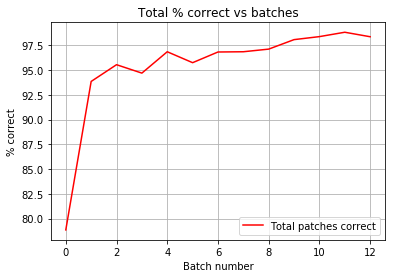

In [44]:
os.chdir(path_fig)
plt.figure(figsize=(9, 6))
fig = plt.figure()
plt.plot(total_plot[:13],c='r', label='Total patches correct')
plt.legend(loc='lower right')
plt.title('Total % correct vs batches')
plt.xlabel('Batch number')
plt.ylabel('% correct')
plt.grid()
fig.savefig('RF_class_resnet50_4D.pdf', format="pdf")
plt.show()

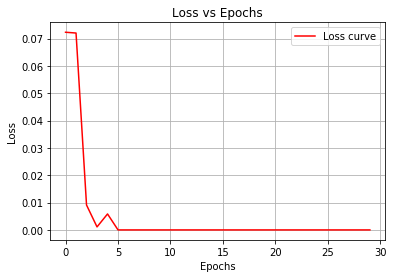

In [45]:
os.chdir(path_fig)
plt.figure(figsize=(9, 6))
fig = plt.figure()
plt.plot(loss_plot,c='r', label='Loss curve')
plt.legend(loc='upper right')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
fig.savefig('RF_class_v56_loss_4D.pdf', format="pdf")
plt.show()

#### Testing from saved recording data

### LIVE inferencing

In [138]:
# !python3 /home/david/sigMF_ML/gnuradio/record_live.py

###  TESTING

[INFO] [UHD] linux; GNU C++ version 7.5.0; Boost_106501; UHD_3.15.0.0-62-g7a3f1516
[INFO] [B200] Detected Device: B205mini
[INFO] [B200] Operating over USB 3.
[INFO] [B200] Initialize CODEC control...
[INFO] [B200] Initialize Radio control...
[INFO] [B200] Performing register loopback test... 
[INFO] [B200] Register loopback test passed
[INFO] [B200] Setting master clock rate selection to 'automatic'.
[INFO] [B200] Asking for clock rate 16.000000 MHz... 
[INFO] [B200] Actually got clock rate 16.000000 MHz.
[INFO] [B200] Asking for clock rate 25.000000 MHz... 
[INFO] [B200] Actually got clock rate 25.000000 MHz.
[INFO] [MULTI_USRP]     1) catch time transition at pps edge
[INFO] [MULTI_USRP]     2) set times next pps (synchronously)
gr::log :INFO: sink0 - No core:datetime found, using host ts instead
inference file name =  test1.sigmf-meta
iq_read_test live: remarked out plotting
gpu_test live function
25600 MSPS
FINAL gpu_test LIVE IQ shape = torch.Size([12800, 9766, 4])
iq_read_test l

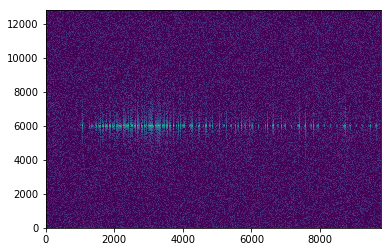

start_frequency =  428.0
sigmf_data =  (12800, 9766, 4)
frequency =  12800   time =  9766
seg_time =  43 seg_freq =  57
data_IQ shape =  (2451, 224, 224, 4)
testing counter =  tensor([2451]) seg_freq = tensor([57])
seg_freq =  tensor([57])


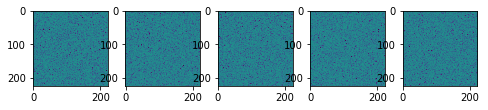

freq_increment =  219298.24561403508
TESTING inputs SHAPE =  torch.Size([1, 2451, 224, 224, 4])
input in   =  torch.Size([1, 2451, 224, 224, 4])
input out  =  torch.Size([2451, 224, 224, 4])
counter convert stuff =  tensor([2451]) <class 'numpy.ndarray'>
permuted shape =  torch.Size([2451, 4, 224, 224])
mean Freq =    432.76
std Freq =      2.19
length of inputs =  2451


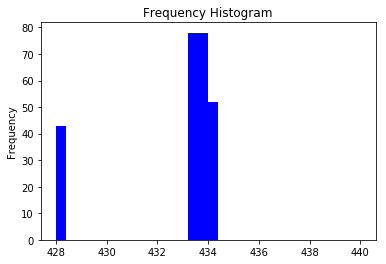

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 16.73%
NFM = 0.00%
TYT = 52.59
Vodeson Doorbell = 0.40%
clickndig = 0.00%
Sado doorbell = 17.53%
LoRa 250 = 0.00%
light switch = 12.75%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2200
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************


In [138]:
msps = 25
center_freq_live = 428.0e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
!python3 /home/david/sigMF_ML/gnuradio/record_live_25msps.py
# !python3 /home/david/sigMF_ML/gnuradio/record_live1msps.py
# usrp_data_collect_1MSPS()
data_IQ_list_val, meta_list_val = inference_read(msps)
testing_live(msps)
torch.cuda.empty_cache()

[INFO] [UHD] linux; GNU C++ version 7.5.0; Boost_106501; UHD_3.15.0.0-62-g7a3f1516
[INFO] [B200] Detected Device: B205mini
[INFO] [B200] Operating over USB 3.
[INFO] [B200] Initialize CODEC control...
[INFO] [B200] Initialize Radio control...
[INFO] [B200] Performing register loopback test... 
[INFO] [B200] Register loopback test passed
[INFO] [B200] Setting master clock rate selection to 'automatic'.
[INFO] [B200] Asking for clock rate 16.000000 MHz... 
[INFO] [B200] Actually got clock rate 16.000000 MHz.
[INFO] [B200] Asking for clock rate 40.000000 MHz... 
[INFO] [B200] Actually got clock rate 40.000000 MHz.
[INFO] [MULTI_USRP]     1) catch time transition at pps edge
[INFO] [MULTI_USRP]     2) set times next pps (synchronously)
gr::log :INFO: sink0 - No core:datetime found, using host ts instead
inference file name =  test1.sigmf-meta
iq_read_test live: remarked out plotting
gpu_test live function
Sample Rate =  5120 MSPS
FINAL gpu_test LIVE IQ shape = torch.Size([2560, 9766, 4])
i

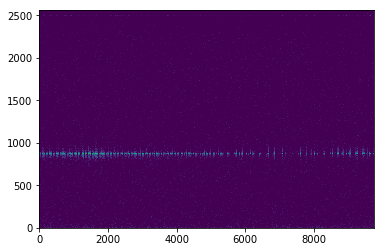

start_frequency =  433.0
sigmf_data =  (2560, 9766, 4)
frequency =  2560   time =  9766
seg_time =  43 seg_freq =  11
data_IQ shape =  (473, 224, 224, 4)
testing counter =  tensor([473]) seg_freq = tensor([11])
seg_freq =  tensor([11])


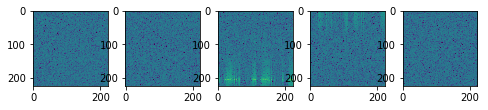

freq_increment =  227272.72727272726
TESTING inputs SHAPE =  torch.Size([1, 473, 224, 224, 4])
input in   =  torch.Size([1, 473, 224, 224, 4])
input out  =  torch.Size([473, 224, 224, 4])
counter convert stuff =  tensor([473]) <class 'numpy.ndarray'>
permuted shape =  torch.Size([473, 4, 224, 224])
mean Freq =    433.68
std Freq =      0.00
length of inputs =  473


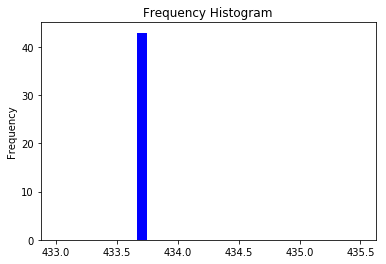

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 2.33%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 97.67%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  430
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************


In [152]:
msps = 5
center_freq_live = 433.0e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
!python3 /home/david/sigMF_ML/gnuradio/record_live_5msps.py
# !python3 /home/david/sigMF_ML/gnuradio/record_live1msps.py
# usrp_data_collect_1MSPS()
data_IQ_list_val, meta_list_val = inference_read(msps)
testing_live(msps)
torch.cuda.empty_cache()

[INFO] [UHD] linux; GNU C++ version 7.5.0; Boost_106501; UHD_3.15.0.0-62-g7a3f1516
[INFO] [B200] Detected Device: B205mini
[INFO] [B200] Operating over USB 3.
[INFO] [B200] Initialize CODEC control...
[INFO] [B200] Initialize Radio control...
[INFO] [B200] Performing register loopback test... 
[INFO] [B200] Register loopback test passed
[INFO] [B200] Setting master clock rate selection to 'automatic'.
[INFO] [B200] Asking for clock rate 16.000000 MHz... 
[INFO] [B200] Actually got clock rate 16.000000 MHz.
[INFO] [B200] Asking for clock rate 32.000000 MHz... 
[INFO] [B200] Actually got clock rate 32.000000 MHz.
[INFO] [MULTI_USRP]     1) catch time transition at pps edge
[INFO] [MULTI_USRP]     2) set times next pps (synchronously)
gr::log :INFO: sink0 - No core:datetime found, using host ts instead
inference file name =  test1.sigmf-meta
iq_read_test live: remarked out plotting
gpu_test live function
Sample Rate =  1024 MSPS
FINAL gpu_test LIVE IQ shape = torch.Size([512, 9766, 4])
iq

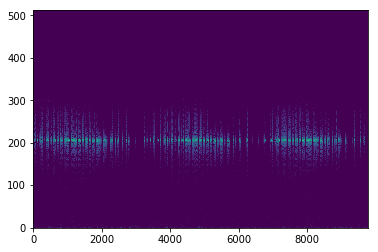

start_frequency =  433.65
sigmf_data =  (512, 9766, 4)
frequency =  512   time =  9766
seg_time =  43 seg_freq =  2
data_IQ shape =  (86, 224, 224, 4)
testing counter =  tensor([86]) seg_freq = tensor([2])
seg_freq =  tensor([2])


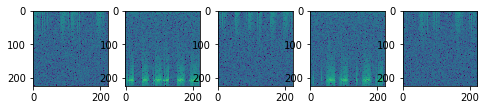

freq_increment =  250000.0
TESTING inputs SHAPE =  torch.Size([1, 86, 224, 224, 4])
input in   =  torch.Size([1, 86, 224, 224, 4])
input out  =  torch.Size([86, 224, 224, 4])
counter convert stuff =  tensor([86]) <class 'numpy.ndarray'>
permuted shape =  torch.Size([86, 4, 224, 224])
mean Freq =    433.65
std Freq =      0.00
length of inputs =  86


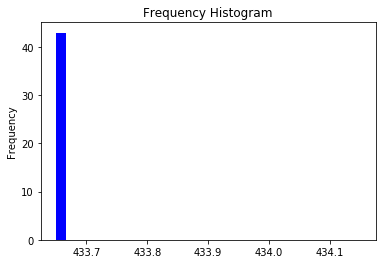

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 100.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  43
center fft matches =  0
TOTAL patch count =  86
***************************** Finished *********************************


In [157]:
msps = 1
center_freq_live = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
# !python3 /home/david/sigMF_ML/gnuradio/record_live25msps.py
!python3 /home/david/sigMF_ML/gnuradio/record_live_1msps.py
# usrp_data_collect_1MSPS()
data_IQ_list_val, meta_list_val = inference_read(msps)
testing_live(msps)
torch.cuda.empty_cache()

In [ ]:
torch.cuda.empty_cache()

## testing pre-recorded files in /home/david/sigMF_ML/RF/RF_class/testing_data

inference file name =  UHF_clickndig_fob1_test1.sigmf-meta
iq_read_test file
gpu_test file function
5120 MSPS
window length =  1024
gpu_test file Z shape = torch.Size([2561, 9766, 4])
imshow method


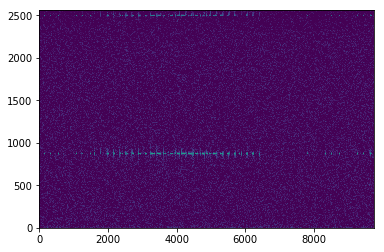

start_frequency =  433.0
sigmf_data =  (2560, 9766, 4)
frequency =  2560   time =  9766
seg_time =  43 seg_freq =  11
data_IQ shape =  (473, 224, 224, 4)
testing counter =  tensor([473]) seg_freq = tensor([11])
freq_increment =  227272.72727272726
TESTING inputs SHAPE =  torch.Size([1, 473, 224, 224, 4])
mean Freq =    433.68
std Freq =      0.00
length of inputs =  473


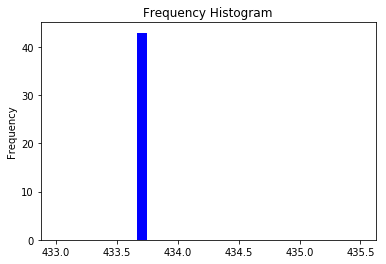

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 4.65%
NFM = 6.98%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 88.37%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  430
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************


In [103]:
msps = 5
center_freq_file = 433.00e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_5msps)
testing_file(msps)
torch.cuda.empty_cache()

inference file name =  UHF_sado_db1_test6.sigmf-meta
iq_read_test file
gpu_test file function
Sample Rate =  25600 MSPS
window length =  1024
gpu_test file Z shape = torch.Size([12801, 9766, 4])
imshow method


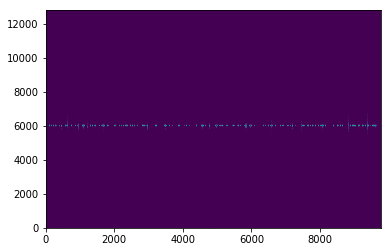

start_frequency =  428.0
sigmf_data =  (12800, 9766, 4)
frequency =  12800   time =  9766
seg_time =  43 seg_freq =  57
data_IQ shape =  (2451, 224, 224, 4)
testing counter =  tensor([2451]) seg_freq = tensor([57])
freq_increment =  219298.24561403508
TESTING inputs SHAPE =  torch.Size([1, 2451, 224, 224, 4])
mean Freq =    433.70
std Freq =      0.00
length of inputs =  2451


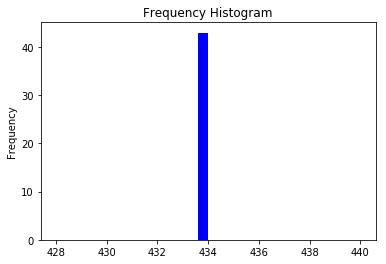

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 100.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2408
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************


In [148]:
msps = 25
center_freq_file = 428.00e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_25msps)
testing_file(msps)
torch.cuda.empty_cache()

inference file name =  UHF_GD55_DMR_talk3_test2.sigmf-meta
iq_read_test file
gpu_test file function
1024 MSPS
window length =  1024
gpu_test file Z shape = torch.Size([513, 19532, 4])
imshow method


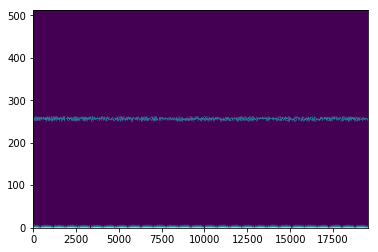

start_frequency =  433.65
sigmf_data =  (512, 19532, 4)
frequency =  512   time =  19532
seg_time =  87 seg_freq =  2
data_IQ shape =  (174, 224, 224, 4)
testing counter =  tensor([174]) seg_freq = tensor([2])
freq_increment =  250000.0
TESTING inputs SHAPE =  torch.Size([1, 174, 224, 224, 4])
mean Freq =    433.90
std Freq =      0.00
length of inputs =  174


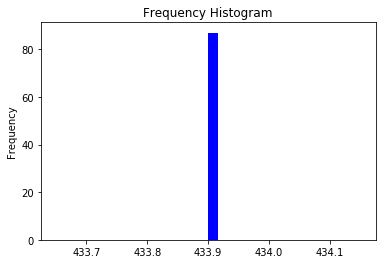

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 97.70%
NFM = 2.30%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************


In [114]:
msps = 1
center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_1msps)
testing_file(msps)
torch.cuda.empty_cache()

In [ ]:
torch.cuda.empty_cache()

#### Save and Load model data

In [42]:
# rf_model = 'ResNet50_v56_20210208_4D_20dB_autosave'

In [43]:
# PATH = path_save+rf_model

In [46]:
load_model()

#### save

In [145]:
# torch.save(model.state_dict(), PATH)

#### load

In [44]:
# device = torch.device("cuda:0")
# model = resnet50(4, 12)
# model.load_state_dict(torch.load(PATH))
# model.to(device)
# model.eval()

ResNet(
  (encoder): ResNetEncoder(
    (gate): Sequential(
      (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (blocks): ModuleList(
      (0): ResNetLayer(
        (blocks): Sequential(
          (0): ResNetBottleNeckBlock(
            (blocks): Sequential(
              (0): Sequential(
                (conv): Conv2dAuto(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (1): ReLU()
              (2): Sequential(
                (conv): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [45]:
# # Print model's state_dict
# print("Model's state_dict:")
# for param_tensor in model.state_dict():
#     print(param_tensor, "\t", model.state_dict()[param_tensor].size())

In [46]:
# # Print optimizer's state_dict
# print("Optimizer's state_dict:")
# for var_name in optimizer.state_dict():
#     print(var_name, "\t", optimizer.state_dict()[var_name])

In [47]:
# # SAVE MODEL
# os.chdir(path_save)
# torch.save({
#            'epoch': epoch,
#            'model_state_dict': model.state_dict(),
#            'optimizer_state_dict': optimizer.state_dict(),
#            'loss': loss,
#            }, path_save+rf_model)

In [48]:
# # LOAD MODEL
# checkpoint = torch.load(path_save+rf_model, map_location=device)


# # STATUS
# checkpoint.keys()

# epoch = checkpoint['epoch']
# model_state_dict = checkpoint['model_state_dict']
# optimizer_state_dict = checkpoint['optimizer_state_dict']
# loss = checkpoint['loss']

# optimizer_state_dict.keys()

# optimizer_state_dict['param_groups']

# loss

# model.load_state_dict(model_state_dict)   

In [49]:
# loss

In [50]:
# optimizer_state_dict.keys()